# Extreme Gradient Boosting

In [1]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

# Data manipulation
import pandas as pd
import numpy as np

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import (
    train_test_split,
    RandomizedSearchCV,
    TimeSeriesSplit,
    cross_val_score
)

# Classifier
from xgboost import XGBClassifier, plot_importance, to_graphviz

# Metrics
from sklearn.metrics import (
    precision_recall_curve,
    roc_curve,
    RocCurveDisplay,
    ConfusionMatrixDisplay
)
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    recall_score,
    precision_score,
    roc_auc_score,
    auc
)

from sklearn.metrics import (
    classification_report,
    confusion_matrix
)


In [2]:
# Load file
df = pd.read_csv('../11_XGBoost/spy.csv', index_col=0, parse_dates=True)[['Adj Close']]
# Calculate returns
df['Returns'] = np.log(df).diff()
df['Ret_1M'] = df['Returns'].rolling(20).sum()
# Output first five values
df.head()

,Adj Close,Returns,Ret_1M
Date,,,
1999-12-31,100.376900,NaN,NaN
2000-01-03,99.394493,-0.009835,NaN
2000-01-04,95.507530,-0.039892,NaN
2000-01-05,95.678391,0.001787,NaN
2000-01-06,94.140717,-0.016202,NaN


In [3]:
# Descriptive statistics
df.describe()

,Adj Close,Returns,Ret_1M
count,5114.000000,5113.000000,5094.000000
mean,136.333938,0.000210,0.004050
std,67.923663,0.012557,0.048516
min,54.184429,-0.115887,-0.370872
25%,87.412493,-0.004649,-0.016835
50%,106.488850,0.000642,0.011823
75%,182.951584,0.005801,0.031307
max,336.362091,0.135577,0.212052


In [4]:
# Check for missing values
df.isnull().sum()

Adj Close     0
Returns       1
Ret_1M       20
dtype: int64

In [5]:
# Create features (predictors) list
features_list = []
for r in range(10, 65, 5):
    df['Ret_'+str(r)] = df.Returns.rolling(r).sum()
    df['Std_'+str(r)] = df.Returns.rolling(r).std()
    features_list.append('Ret_'+str(r))
    features_list.append('Std_'+str(r))
# Drop NaN values
df.dropna(inplace=True)

In [6]:
# Define Target
df['Target'] = np.where(df['Adj Close'].shift(-1)>0.995 * df['Adj Close'],1,0)
# Check output
df.head()

,Adj Close,Returns,Ret_1M,Ret_10,Std_10,Ret_15,Std_15,Ret_20,Std_20,Ret_25,...,Std_40,Ret_45,Std_45,Ret_50,Std_50,Ret_55,Std_55,Ret_60,Std_60,Target
Date,,,,,,,,,,,,,,,,,,,,,
2000-03-28,103.501099,-0.005776,0.097063,0.102992,0.016808,0.099909,0.017161,0.097063,0.016531,0.115189,...,0.015079,0.076137,0.015692,0.030012,0.015742,0.038339,0.015368,0.030650,0.017420,1
2000-03-29,103.608170,0.001034,0.090847,0.080964,0.016388,0.102198,0.017096,0.090847,0.016542,0.104483,...,0.015027,0.065879,0.015623,0.038945,0.015694,0.035949,0.015363,0.041519,0.017367,0
2000-03-30,101.873848,-0.016881,0.073289,0.018427,0.011734,0.056512,0.016967,0.073289,0.017210,0.107945,...,0.015315,0.056956,0.015801,0.013952,0.015853,0.031106,0.015451,0.064530,0.016697,1
2000-03-31,103.030037,0.011285,0.066024,0.023125,0.012035,0.073135,0.016873,0.066024,0.016954,0.122857,...,0.015243,0.072244,0.015850,0.040662,0.015763,0.052389,0.015448,0.074028,0.016749,1
2000-04-03,103.629585,0.005802,0.081618,0.034044,0.011779,0.089925,0.016292,0.081618,0.016677,0.107899,...,0.015233,0.109737,0.015023,0.048626,0.015772,0.044739,0.015368,0.096032,0.016601,0


In [7]:
# Convert to NumPy
X = df.drop(['Adj Close', 'Returns', 'Ret_1M', 'Target'],axis=1)
X.values

array([[ 0.10299217,  0.01680829,  0.09990879, ...,  0.01536765,
         0.03065013,  0.01742033],
       [ 0.08096385,  0.01638798,  0.10219782, ...,  0.01536317,
         0.04151947,  0.01736735],
       [ 0.01842677,  0.01173377,  0.05651238, ...,  0.01545088,
         0.06453017,  0.01669711],
       ...,
       [ 0.04048814,  0.02113725,  0.14546178, ...,  0.03983401,
        -0.12651806,  0.03830417],
       [ 0.00681279,  0.01931243,  0.07584602, ...,  0.03983321,
        -0.11280233,  0.03824664],
       [ 0.05413158,  0.01907551,  0.10066876, ...,  0.03999635,
        -0.09436169,  0.03839629]])

In [8]:
# Define label or target
y = df['Target']
y

Date
2000-03-28    1
2000-03-29    0
2000-03-30    1
2000-03-31    1
2000-04-03    0
             ..
2020-04-23    1
2020-04-24    1
2020-04-27    1
2020-04-28    1
2020-04-29    0
Name: Target, Length: 5054, dtype: int64

In [9]:
# Splitting the datasets into training and testing data.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)
# Output the train and test data size
print(f"Train and Test Size {len(X_train)}, {len(X_test)}")

Train and Test Size 4043, 1011


In [10]:
# Scale and fit the classifier model
model = XGBClassifier(verbosity = 0, silent=True, random_state=42)
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

In [11]:
# Predicting the test dataset
y_pred = model.predict(X_test)
# Predict Probabilities
y_proba = model.predict_proba(X_test)

In [12]:
acc_train = accuracy_score(y_train, model.predict(X_train))
acc_test = accuracy_score(y_test, y_pred)

print(f'Train Accuracy: {acc_train:0.4}, Test Accuracy: {acc_test:0.4}')

Train Accuracy: 0.9864, Test Accuracy: 0.7656


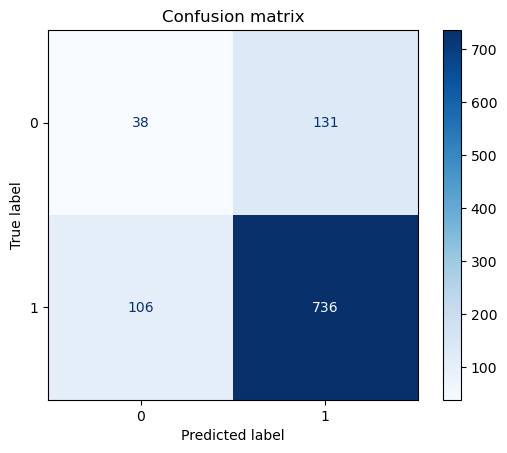

In [13]:
# Display confussion matrix
disp = ConfusionMatrixDisplay.from_estimator(
model,
X_test,
y_test,
display_labels=model.classes_,
cmap=plt.cm.Blues
)
disp.ax_.set_title('Confusion matrix')
plt.show()

In [14]:
# Classification Report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.26      0.22      0.24       169
           1       0.85      0.87      0.86       842

    accuracy                           0.77      1011
   macro avg       0.56      0.55      0.55      1011
weighted avg       0.75      0.77      0.76      1011



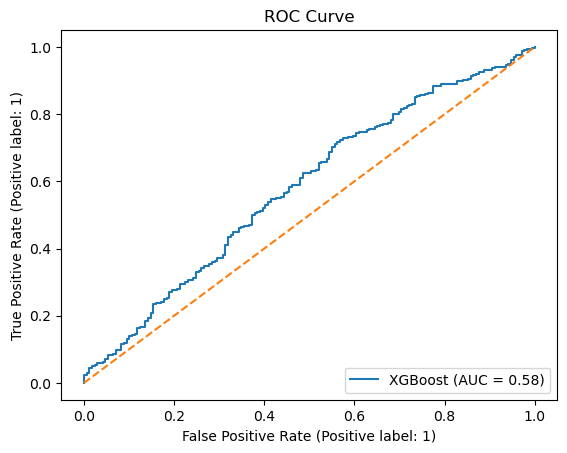

In [15]:
# Display ROCCurve
disp_roc = RocCurveDisplay.from_estimator(
        model,
        X_test,
        y_test,
name='XGBoost')
disp_roc.ax_.set_title('ROC Curve')
plt.plot([0,1], [0,1], linestyle='--')
plt.show()

## Tuning Hyper-params

- learning rate: step size shrinkage used in update to prevents overfitting. Range is [0,1].
- max_depth: maximum depth of a tree.
- colsample_bytree: percentage of features used per tree. High value can lead to overfitting.
- min_child_weight: minimum sum of instance weight needed in a child.
- gamma: minimum loss reduction required to make a further partition on a leaf node of the
tree. Large gamma will lead to more conservative algorithm.
- lambda: L2 regularization term on weights. Increasing this value will make model more
conservative. Normalised to number of training examples. [parameter for linear booster].

In [16]:
# Cross-validation
tscv = TimeSeriesSplit(n_splits=5, gap=1)

In [17]:
# Get params list
model.get_params()

{'objective': 'binary:logistic',
 'use_label_encoder': None,
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'gpu_id': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 100,
 'n_jobs': None,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': 42,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': 0,
 'silent': True}

In [18]:
# Hyper parameter optimization
param_grid = {  'learning_rate': [0.05, 0.10, 0.15, 0.20, 0.25, 0.30],
                'max_depth': [3, 4, 5, 6, 8, 10, 12, 15],
                'min_child_weight': [1, 3, 5, 7],
                'gamma': [0.0, 0.1, 0.2 , 0.3, 0.4],
                'colsample_bytree': [0.3, 0.4, 0.5 , 0.7]
            }

In [19]:
# perform random search
rs = RandomizedSearchCV(model, param_grid, n_iter=100, scoring='f1', cv=tscv, verbose=0)
rs.fit(X_train, y_train, verbose=0)

RandomizedSearchCV(cv=TimeSeriesSplit(gap=1, max_train_size=None, n_splits=5, test_size=None),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=N...
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100, n_jobs=None,
                                           num_parallel_tree=None,
                                           predictor=None, random_state=42, ...),
                   n_iter=100,
                   param_distributions={'colsample_bytree': [0.3, 0.4, 0.5,
                                                             0.7],
                                        'gamma': [0.0, 0.1, 0.2, 0.3, 0.4],
                                        'learning_rate': [0.05, 0.1, 0.15, 0.2,
                                                          0.25, 0.3],
                                        'max_depth': [3, 4, 5, 6, 8, 10, 12,
                                                      15],
                                        'min_child_weight': [1, 3, 5, 7]},
                   scoring='f1')

In [20]:
# best parameters
rs.best_params_

{'min_child_weight': 7,
 'max_depth': 4,
 'learning_rate': 0.05,
 'gamma': 0.1,
 'colsample_bytree': 0.4}

In [21]:
# best score
rs.best_score_

0.82132798375661

## Tunned model

In [22]:
# Refit the XGB Classifier with the best params
cls = XGBClassifier(**rs.best_params_)
cls.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    # eval_metric='logloss',
    verbose=True
    )

[0]	validation_0-logloss:0.67956	validation_1-logloss:0.67408
[1]	validation_0-logloss:0.66728	validation_1-logloss:0.65618
[2]	validation_0-logloss:0.65620	validation_1-logloss:0.64006
[3]	validation_0-logloss:0.64602	validation_1-logloss:0.62502
[4]	validation_0-logloss:0.63672	validation_1-logloss:0.61306
[5]	validation_0-logloss:0.62818	validation_1-logloss:0.60197
[6]	validation_0-logloss:0.62052	validation_1-logloss:0.59017
[7]	validation_0-logloss:0.61333	validation_1-logloss:0.57943
[8]	validation_0-logloss:0.60656	validation_1-logloss:0.56952
[9]	validation_0-logloss:0.60050	validation_1-logloss:0.56034
[10]	validation_0-logloss:0.59491	validation_1-logloss:0.55224
[11]	validation_0-logloss:0.58972	validation_1-logloss:0.54514
[12]	validation_0-logloss:0.58489	validation_1-logloss:0.53798
[13]	validation_0-logloss:0.58048	validation_1-logloss:0.53168
[14]	validation_0-logloss:0.57635	validation_1-logloss:0.52578
[15]	validation_0-logloss:0.57264	validation_1-logloss:0.52005
[1

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.4, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.1, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=7, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [23]:
# Cross validation score
score = cross_val_score(cls,X_train,y_train,cv=tscv)
print(f'Mean CV Score : {score.mean():0.4}')

Mean CV Score : 0.7126


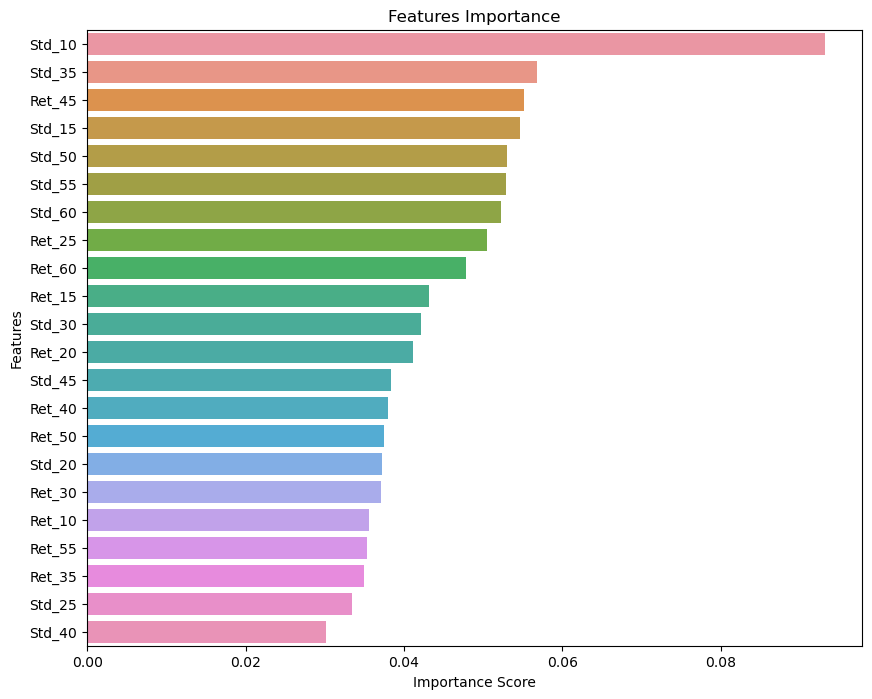

In [24]:
# Plot feature importance
fig, ax = plt.subplots(figsize=(10,8))
feature_imp = pd.DataFrame({'Importance Score': cls.feature_importances_,'Features': X.columns}).sort_values(by='Importance Score', ascending=False)
sns.barplot(x=feature_imp['Importance Score'], y=feature_imp['Features'])
ax.set_title('Features Importance');

In [25]:
# The Gain is the most relevant attribute to interpret the relative importance of each feature.
plot_importance?

Signature:
plot_importance(
    booster: xgboost.core.Booster,
    ax: Optional[Any] = None,
    height: float = 0.2,
    xlim: Optional[tuple] = None,
    ylim: Optional[tuple] = None,
    title: str = 'Feature importance',
    xlabel: str = 'F score',
    ylabel: str = 'Features',
    fmap: Union[str, os.PathLike] = '',
    importance_type: str = 'weight',
    max_num_features: Optional[int] = None,
    grid: bool = True,
    show_values: bool = True,
    **kwargs: Any,
) -> Any
Docstring:
Plot importance based on fitted trees.

Parameters
----------
booster : Booster, XGBModel or dict
    Booster or XGBModel instance, or dict taken by Booster.get_fscore()
ax : matplotlib Axes, default None
    Target axes instance. If None, new figure and axes will be created.
grid : bool, Turn the axes grids on or off.  Default is True (On).
importance_type : str, default "weight"
    How the importance is calculated: either "weight", "gain", or "cover"

    * "weight" is the number of times a feat

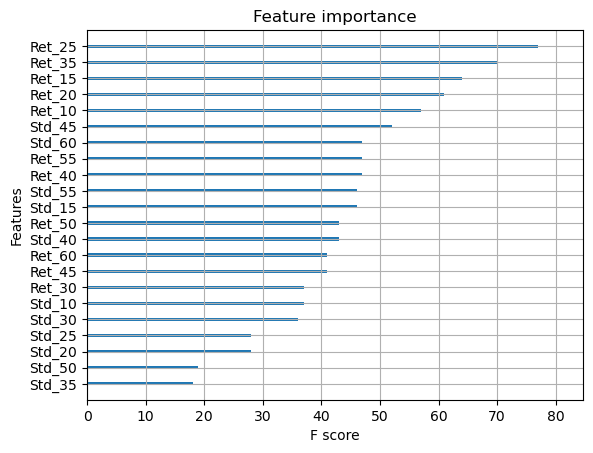

In [26]:
# feature importance_type = 'gain'
plot_importance(cls, importance_type='weight', show_values=False);

In [27]:
import shap
explainer = shap.TreeExplainer(cls)
shap_values = explainer.shap_values(X_test)

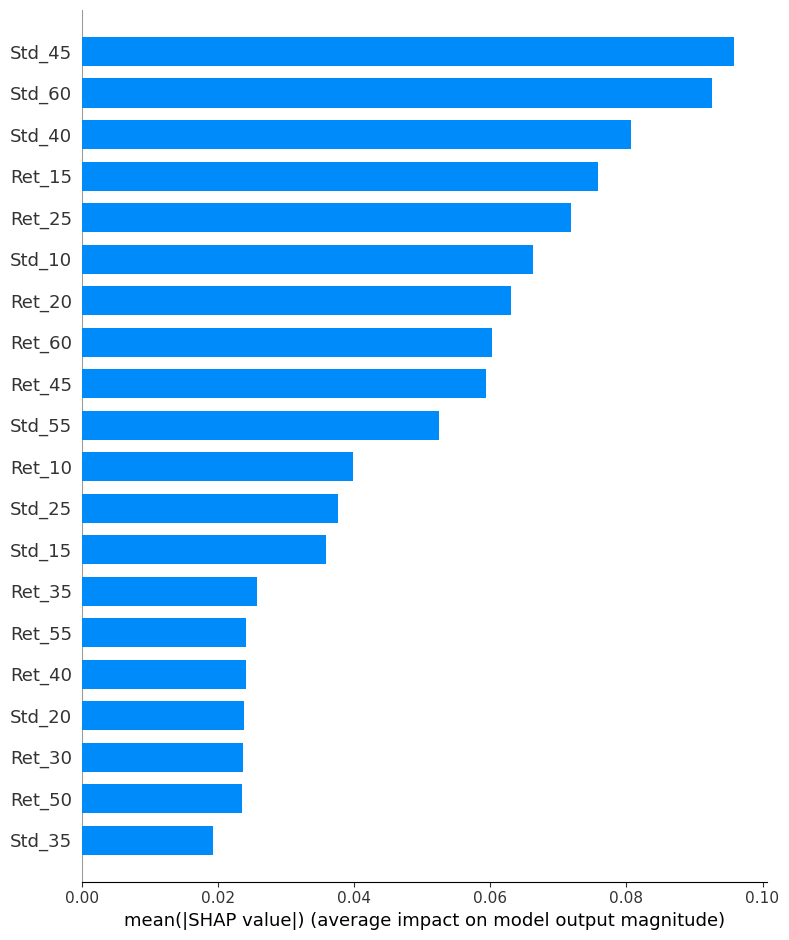

In [28]:
# future importance summary
shap.summary_plot(shap_values, X_test, plot_type="bar")

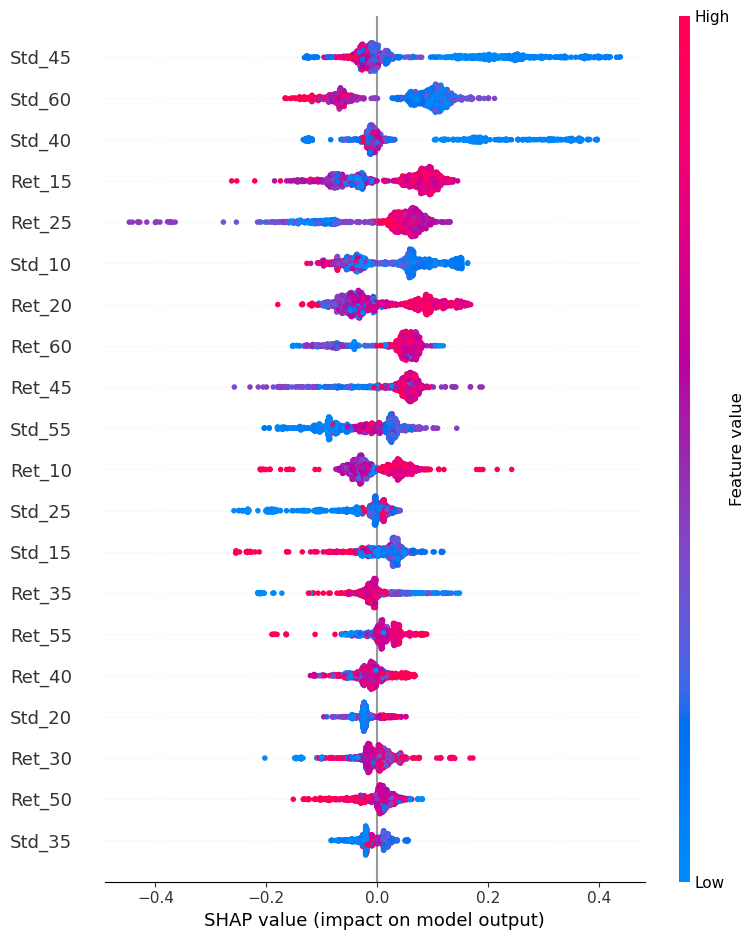

In [29]:
# interpretation plot
shap.summary_plot(shap_values, X_test)

In [31]:
## Tree Visualization
# change tree number to see the corresponding plot
to_graphviz(cls, num_trees=10, rankdir='UT')

ImportError: You must install graphviz to plot tree

In [32]:
# Predicting the test dataset
y_pred = cls.predict(X_test)
# Measure Accuracy
acc_train = accuracy_score(y_train, cls.predict(X_train))
acc_test = accuracy_score(y_test, y_pred)
# Print Accuracy
print(f'\n Training Accuracy \t: {acc_train :0.4} \n Test Accuracy \t\t: {acc_test :0.4}')


 Training Accuracy 	: 0.7541 
 Test Accuracy 		: 0.8289


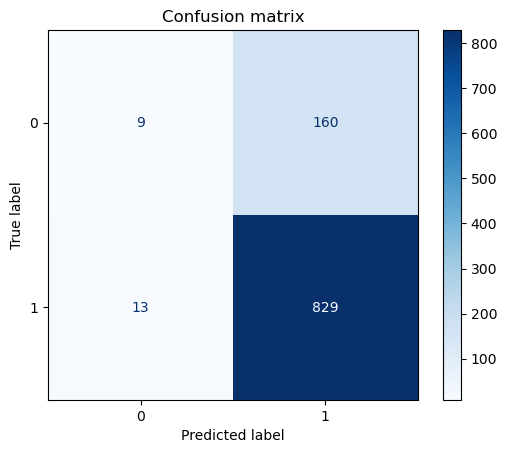

In [33]:
# Display confussion matrix
disp = ConfusionMatrixDisplay.from_estimator(
        cls,
        X_test,
        y_test,
        display_labels=model.classes_,
        cmap=plt.cm.Blues
    )   
disp.ax_.set_title('Confusion matrix')
plt.show()

In [34]:
# Classification Report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.41      0.05      0.09       169
           1       0.84      0.98      0.91       842

    accuracy                           0.83      1011
   macro avg       0.62      0.52      0.50      1011
weighted avg       0.77      0.83      0.77      1011



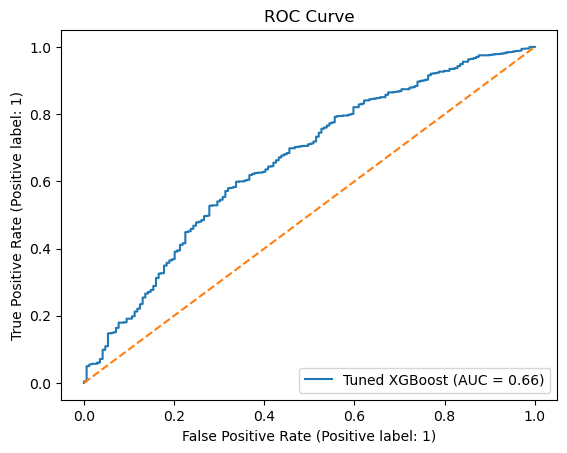

In [35]:
# Display ROCCurve
disp_roc = RocCurveDisplay.from_estimator(
        cls,
        X_test,
        y_test,
        name='Tuned XGBoost')
disp_roc.ax_.set_title('ROC Curve')
plt.plot([0,1], [0,1], linestyle='--')
plt.show()